# Feature selection

Training data contains a lot of correlated, redundant, un-trainable or otherwise likely unnecessary features. Plan here is to work through some standard feature selection techniques from scikit-learn to see if we can come up with a good, minimal feature-set to cary forward for other experiments.

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pickle
# import pandas as pd
import matplotlib.pyplot as plt

import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import configuration as config

/mnt/arkk/llm_detector/classifier


## 1. Load and prepare data

In [2]:
with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'rb') as file:
    data = pickle.load(file)

# Prepare data for classifier training
features_train_df, features_test_df, labels_train, labels_test = helper_funcs.prep_training_data(data)

# Grab the original feature names for future reference
feature_column_names = features_train_df.columns
feature_column_names

Training data: 21443 examples
Test data: 5361 examples


Index(['Fragment length (words)', 'Fragment length (tokens)', 'Perplexity',
       'Cross-perplexity', 'Perplexity ratio score',
       'Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score',
       'Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score',
       'Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score',
       'Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score',
       'Human TF-IDF', 'Synthetic TF-IDF', 'TF-IDF score',
       'Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score',
       'Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score',
       'Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score',
       'Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score'],
      dtype='object')

Next, standard scale the data. This is not strictly necessary for a tree-based classifier, but it will be helpful when eyeballing the data.

In [3]:
features_train_df, features_test_df = helper_funcs.standard_scale_data(features_train_df, features_test_df, feature_column_names)

Take a look at the features we are working with:

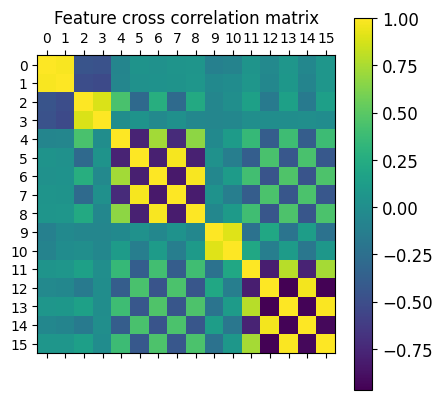

In [4]:
plot_funcs.plot_cross_correlation_matrix(features_train_df).show()

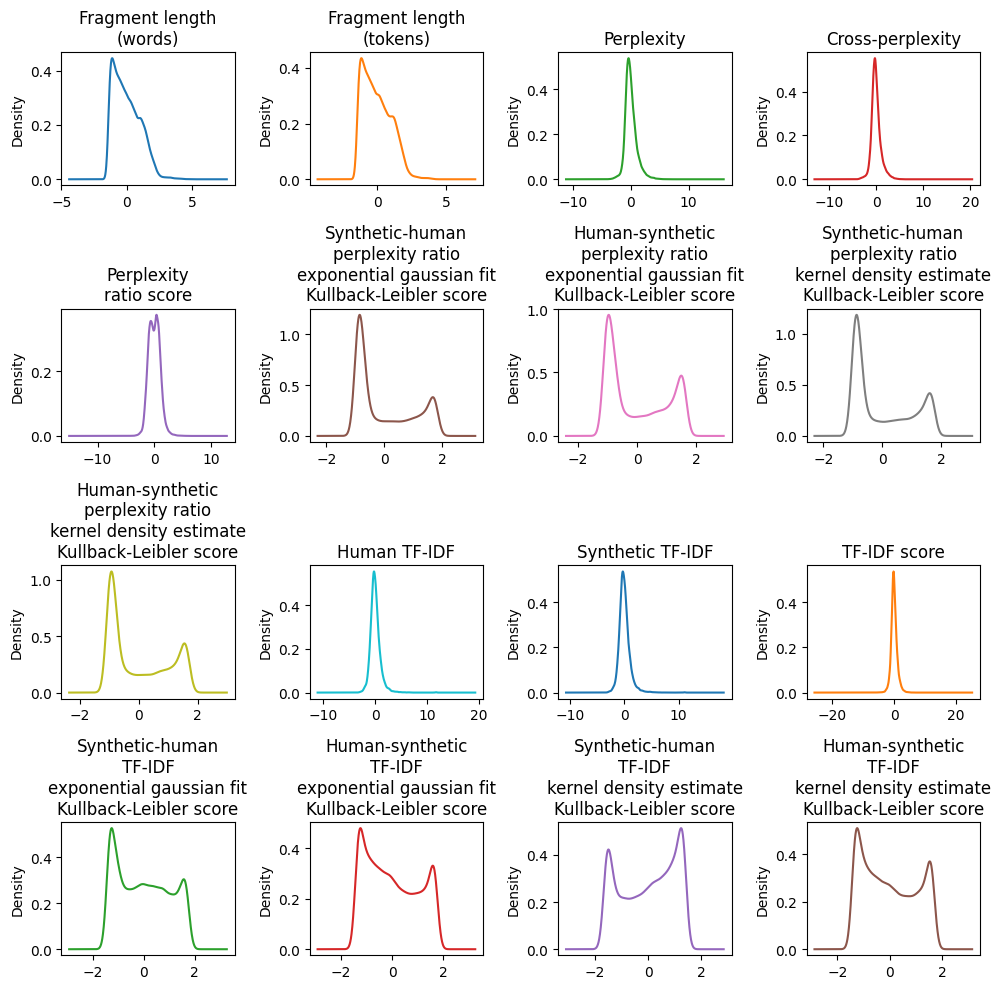

In [5]:
plot_funcs.plot_feature_distributions(features_train_df).show()

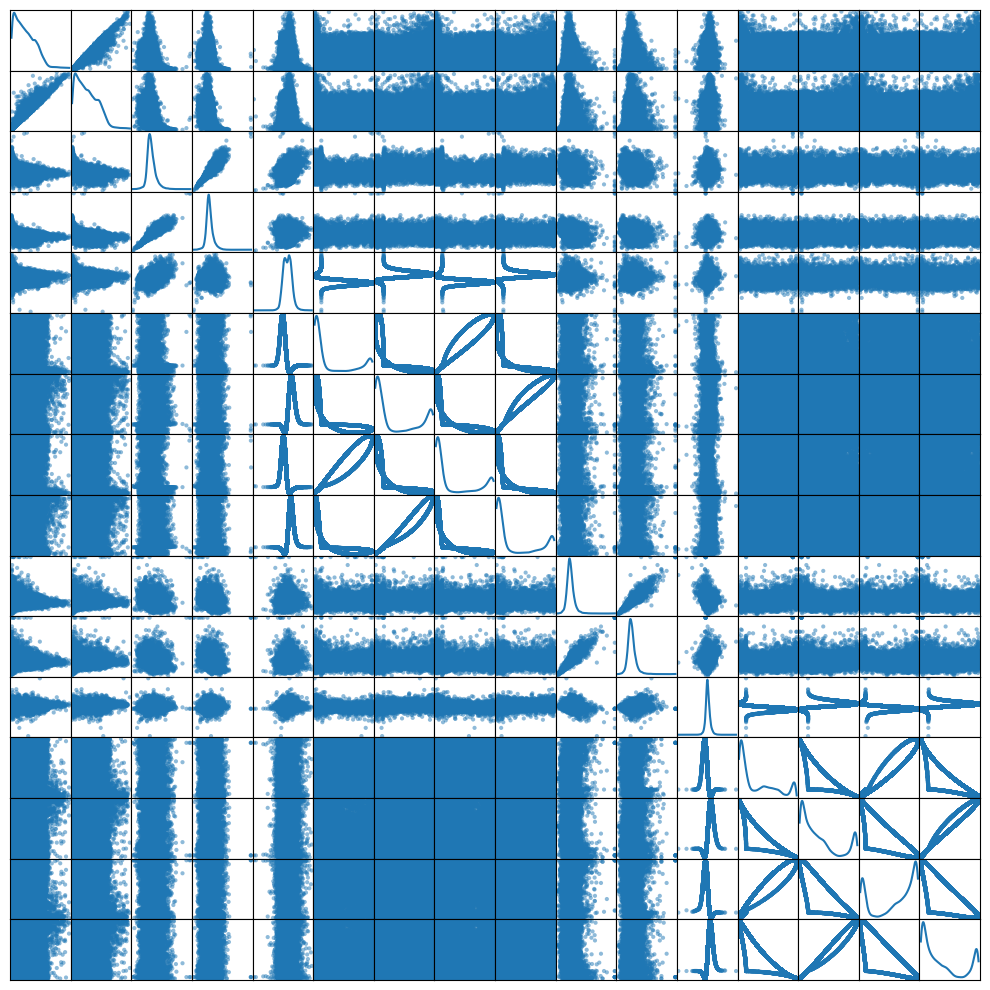

In [6]:
plot_funcs.plot_scatter_matrix(features_train_df).show()

Just for fun let's add some synthetic features to the dataset:

In [7]:
poly_features_train, poly_features_test = helper_funcs.add_poly_features(features_train_df, features_test_df)

Polynomial training data shape: (21443, 153)
Polynomial testing data shape: (5361, 153)


In [8]:
spline_features_train, spline_features_test = helper_funcs.add_spline_features(features_train_df, features_test_df)

Polynomial training data shape: (21443, 112)
Polynomial testing data shape: (5361, 112)


## 2. Univariate feature selection

In [9]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

### 2.1. Mutual information
#### 2.1.1 Original feature set

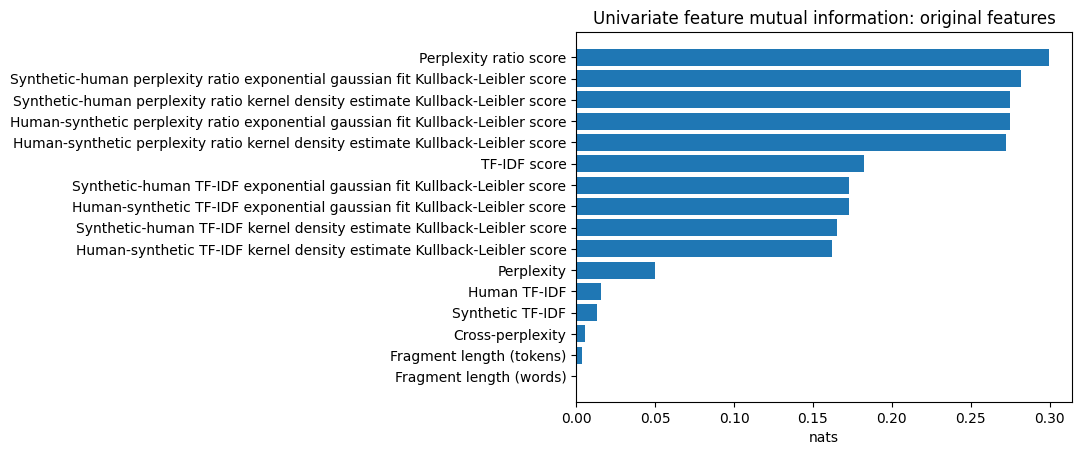

In [10]:
results = mutual_info_classif(features_train_df, labels_train)

univariate_mi_results = {}

for feature, result in zip(feature_column_names, results):
    univariate_mi_results[feature] = result

univariate_mi_results = dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: original features')

plt.barh(
    np.arange(len(univariate_mi_results.values())),
    univariate_mi_results.values(),
    tick_label = list(univariate_mi_results.keys())
)

plt.xlabel('nats')

plt.show()

#### 2.1.2. Spline synthetic feature set

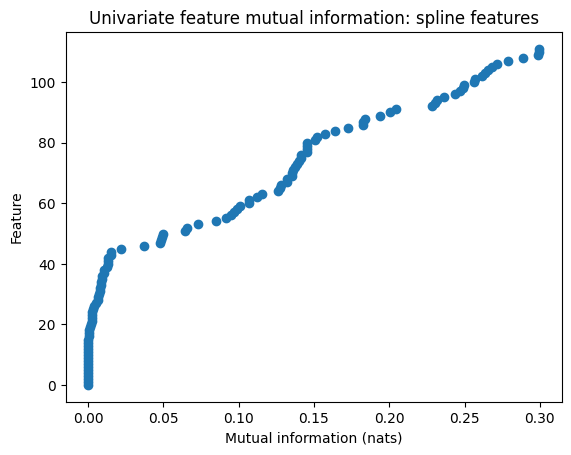

In [11]:
results = mutual_info_classif(spline_features_train, labels_train)

univariate_mi_results = {}

for feature, result in enumerate(results):
    univariate_mi_results[feature] = result

univariate_mi_results = dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: spline features')

plt.scatter(
    univariate_mi_results.values(),
    np.arange(len(univariate_mi_results.values()))
)

plt.xlabel('Mutual information (nats)')
plt.ylabel('Feature')

plt.show()

#### 2.1.3. Polynomial synthetic feature set

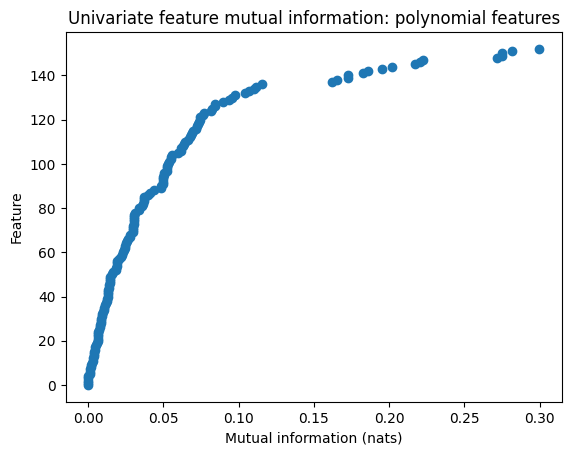

In [12]:
results = mutual_info_classif(poly_features_train, labels_train)

univariate_mi_results = {}

for feature, result in enumerate(results):
    univariate_mi_results[feature] = result

univariate_mi_results = dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: polynomial features')

plt.scatter(
    univariate_mi_results.values(),
    np.arange(len(univariate_mi_results.values()))
)

plt.xlabel('Mutual information (nats)')
plt.ylabel('Feature')

plt.show()

### 2.2. F-Test
#### 2.2.1. Original feature set

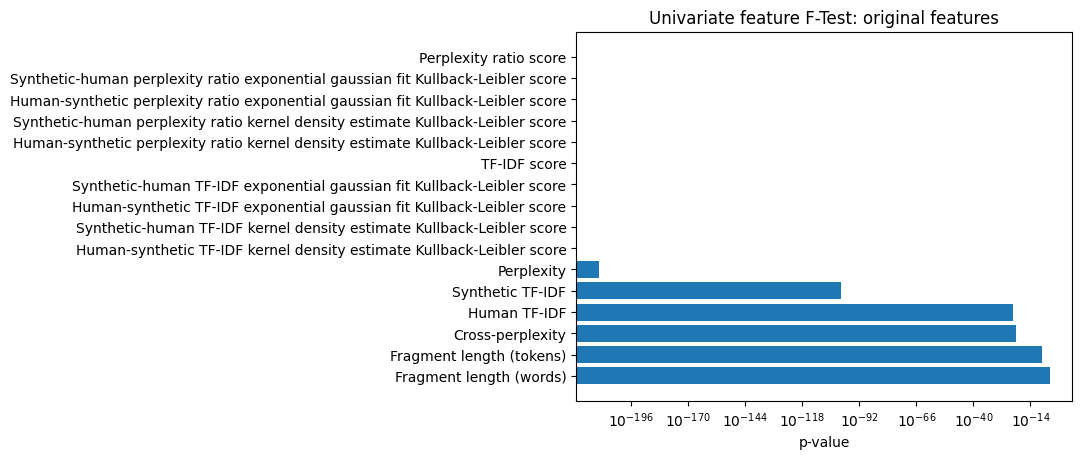

In [13]:
selector = SelectKBest(f_classif, k=4)
selector.fit(features_train_df, labels_train)

univariate_ftest_results = {}

for feature, result in zip(feature_column_names, selector.pvalues_):
    univariate_ftest_results[feature] = result

univariate_ftest_results = dict(reversed(sorted(univariate_ftest_results.items(), key=lambda item: item[1])))

plt.title('Univariate feature F-Test: original features')

plt.barh(
    np.arange(len(univariate_ftest_results.values())),
    univariate_ftest_results.values(),
   
    tick_label=list(univariate_ftest_results.keys())
)
plt.xscale('log')
plt.xlabel('p-value')

plt.show()

#### 2.2.2. Spline synthetic feature set

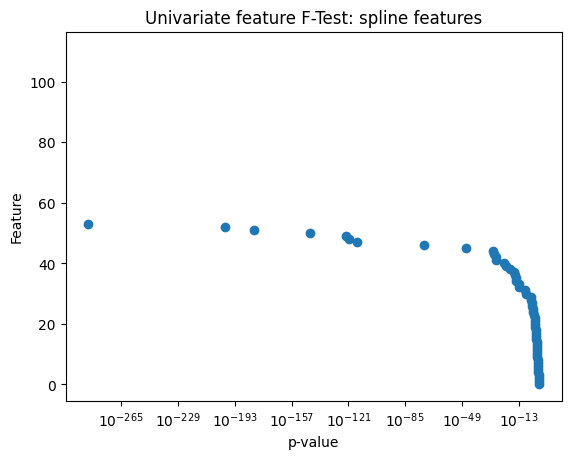

In [14]:
selector = SelectKBest(f_classif, k=4)
selector.fit(spline_features_train, labels_train)

univariate_ftest_results = {}

for feature, result in enumerate(selector.pvalues_):
    univariate_ftest_results[feature] = result

univariate_ftest_results = dict(reversed(sorted(univariate_ftest_results.items(), key=lambda item: item[1])))

plt.title('Univariate feature F-Test: spline features')

plt.scatter(
    univariate_ftest_results.values(),
    np.arange(len(univariate_ftest_results.values()))
)
plt.xscale('log')
plt.xlabel('p-value')
plt.ylabel('Feature')

plt.show()

#### 2.2.3. Polynomial synthetic feature set

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


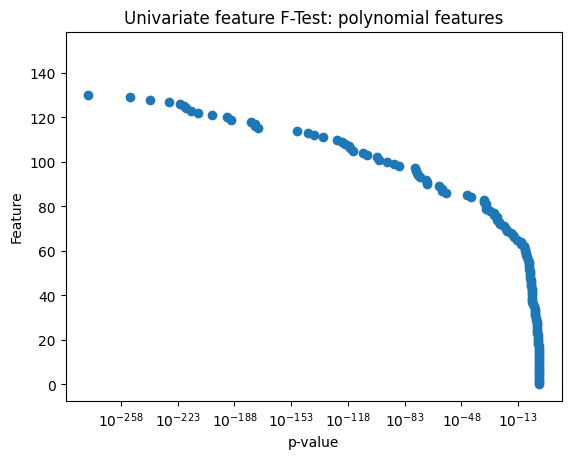

In [15]:
selector = SelectKBest(f_classif, k=4)
selector.fit(poly_features_train, labels_train)

univariate_ftest_results = {}

for feature, result in enumerate(selector.pvalues_):
    univariate_ftest_results[feature] = result

univariate_ftest_results = dict(reversed(sorted(univariate_ftest_results.items(), key=lambda item: item[1])))

plt.title('Univariate feature F-Test: polynomial features')

plt.scatter(
    univariate_ftest_results.values(),
    np.arange(len(univariate_ftest_results.values()))
)
plt.xscale('log')
plt.xlabel('p-value')
plt.ylabel('Feature')

plt.show()

OK, cool - both methods seem to agree and many of our features are clearly significant. Question is now, do we need all of them? We already know we have some highly correlated/similar features that we could probably afford to loose.

## 3. Recursive feature elimination

In [16]:
cv_folds = 3

### 3.1. Original feature set

Optimal number of features: 9


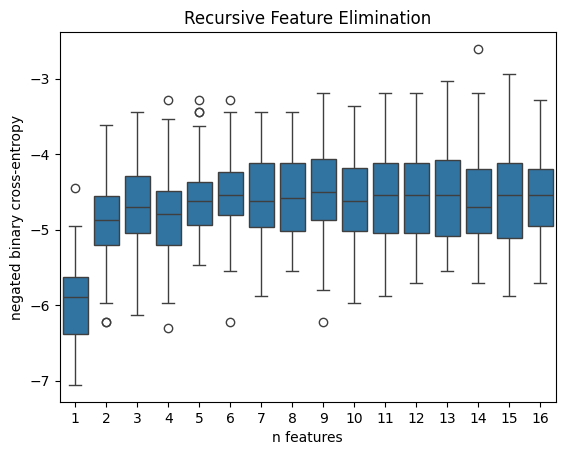

In [17]:
rfecv, cv_results, plt = helper_funcs.recursive_feature_elimination(
    features_train_df = features_train_df,
    labels_train = labels_train,
    cv_folds = 50,
    n_jobs = 5
)

optimal_feature_count = rfecv.n_features_
plt.show()

### 3.2. Spline synthetic feature set

Optimal number of features: 76


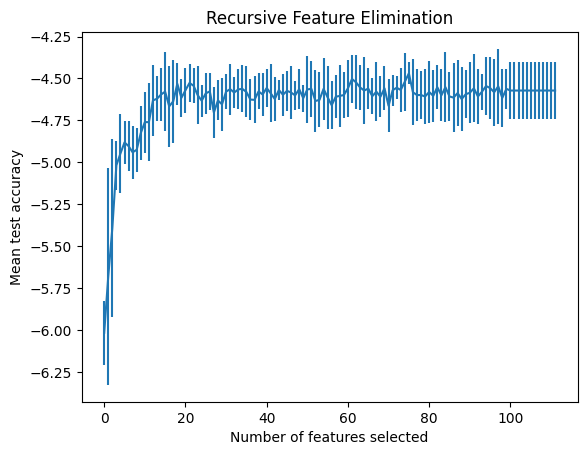

In [18]:
spline_rfecv, spline_cv_results, spline_plt = helper_funcs.recursive_feature_elimination(
    features_train_df = spline_features_train, 
    labels_train = labels_train, 
    cv_folds = 3,
    n_jobs = 5
)

optimal_spline_feature_count = spline_rfecv.n_features_
spline_plt.show()

### 3.3. Polynomial synthetic feature set

Optimal number of features: 150


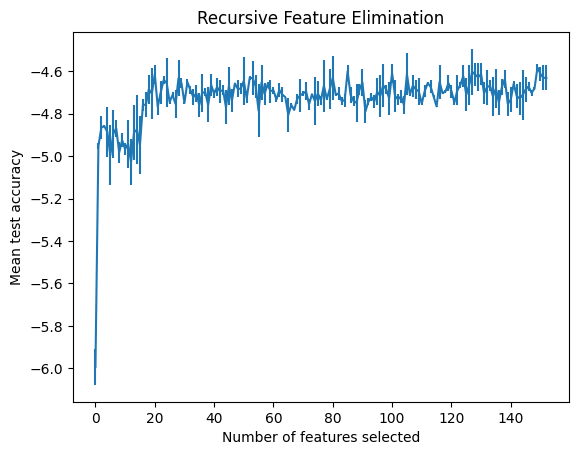

In [19]:
poly_rfecv, poly_cv_results, poly_plt = helper_funcs.recursive_feature_elimination(
    features_train_df = poly_features_train, 
    labels_train = labels_train, 
    cv_folds = 2,
    n_jobs = 5
)

optimal_poly_feature_count = poly_rfecv.n_features_
poly_plt.show()

## 4. Sequential feature selection

### 3.1. Original feature set

In [20]:
#sfs, fitted_sfs = helper_funcs.sequential_feature_selection(features_train_df, labels_train, optimal_feature_count, 50, 5)

### 3.2. Polynomial synthetic feature set

In [21]:
#poly_sfs, poly_fitted_sfs = helper_funcs.sequential_feature_selection(poly_features_train, labels_train, optimal_poly_feature_count, 3, 5)

## 5. Reduced feature set evaluation

After a bunch of fiddling around, it seems like the sweet spot for number of features is around 7 or 8 for the original set and 30 or so for the polynomial set. Though, this seems highly dependent on the number of cross-validation folds and the split method. Also, *RFECV* and *SequentialFeatureSelector* seem to often disagree on exactly what those features should be. I think it's time to generate datasets with those numbers of features and train and evaluate some classifiers.

In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Dictionary to hold results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

### 5.1. Original feature set

Data shape: (21443, 1)
Data shape: (21443, 2)
Data shape: (21443, 3)
Data shape: (21443, 4)
Data shape: (21443, 5)
Data shape: (21443, 6)
Data shape: (21443, 7)
Data shape: (21443, 8)
Data shape: (21443, 9)
Data shape: (21443, 10)
Data shape: (21443, 11)
Data shape: (21443, 12)
Data shape: (21443, 13)
Data shape: (21443, 14)
Data shape: (21443, 15)


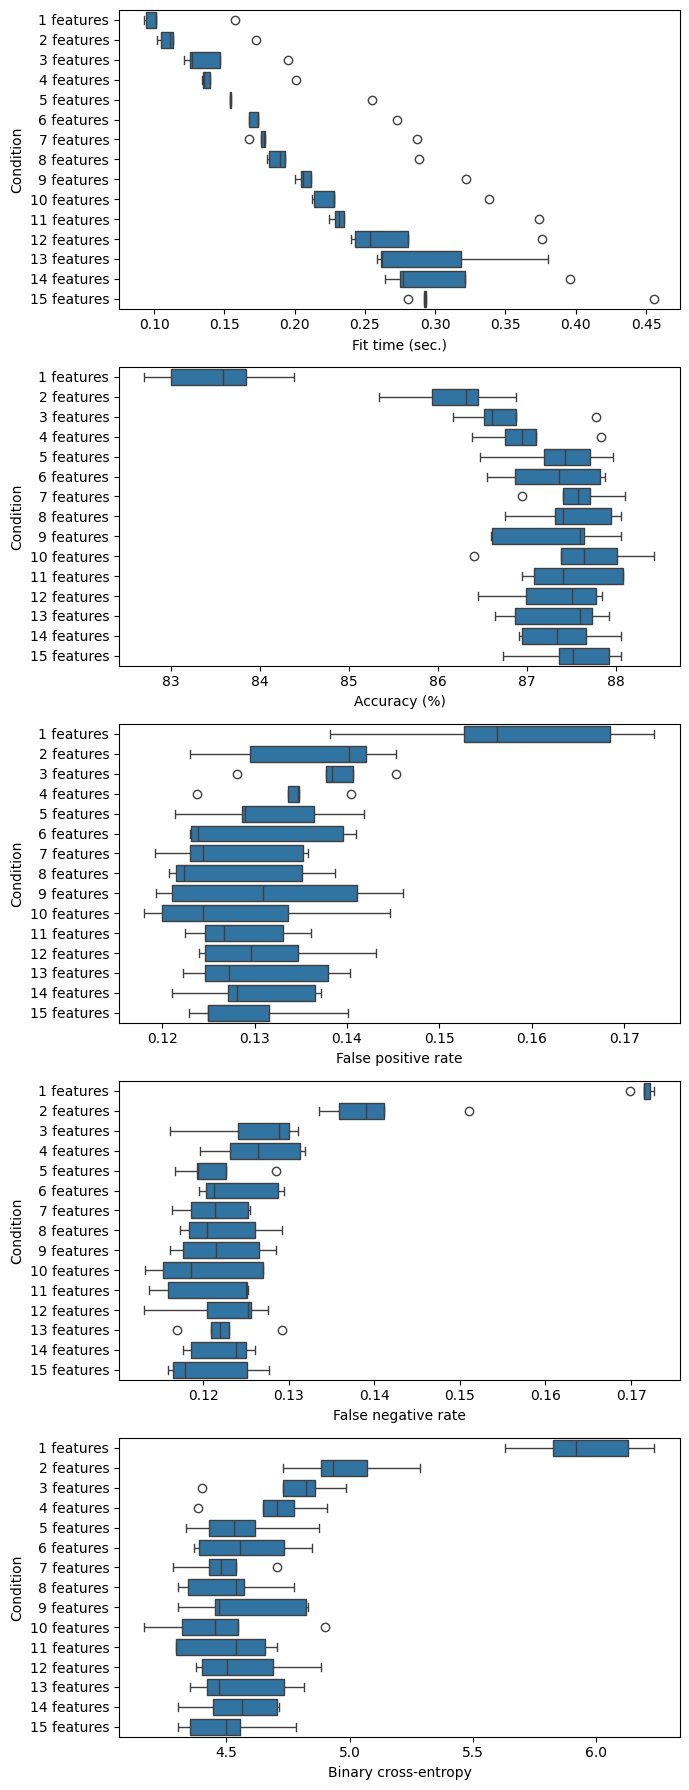

In [23]:
# The feature set sizes to test
feature_set_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# Cross validation folds to run
kfolds = 5

# Number of jobs to run in parallel
parallel_jobs = 5

# Loop on the feature set sizes
for feature_set_size in feature_set_sizes:

    # Run sequential feature selection for this feature set size
    sfs, fitted_sfs = helper_funcs.sequential_feature_selection(
        features_train = features_train_df, 
        labels_train = labels_train, 
        feature_count = feature_set_size, 
        cv_folds = kfolds,
        n_jobs = parallel_jobs
    )

    feature_set_train = fitted_sfs.transform(features_train_df)
    print(f'Data shape: {feature_set_train.shape}')

    # Instantiate an XGBoost model using the sklearn API
    model = XGBClassifier()

    # Run cross-validation
    scores = cross_validate(
        model,
        feature_set_train,
        labels_train,
        cv = kfolds,
        n_jobs = parallel_jobs,
        scoring = scoring
    )

    # Collect the results
    results = helper_funcs.add_cv_scores(results, scores, f'{feature_set_size} features')

plot_funcs.plot_cross_validation(plots, results).show()

### 5.2. Spline synthetic feature set

In [ ]:
# Clear the results dictionary
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

Data shape: (21443, 20)
Data shape: (21443, 25)
Data shape: (21443, 30)
Data shape: (21443, 35)
Data shape: (21443, 40)
Data shape: (21443, 45)
Data shape: (21443, 50)


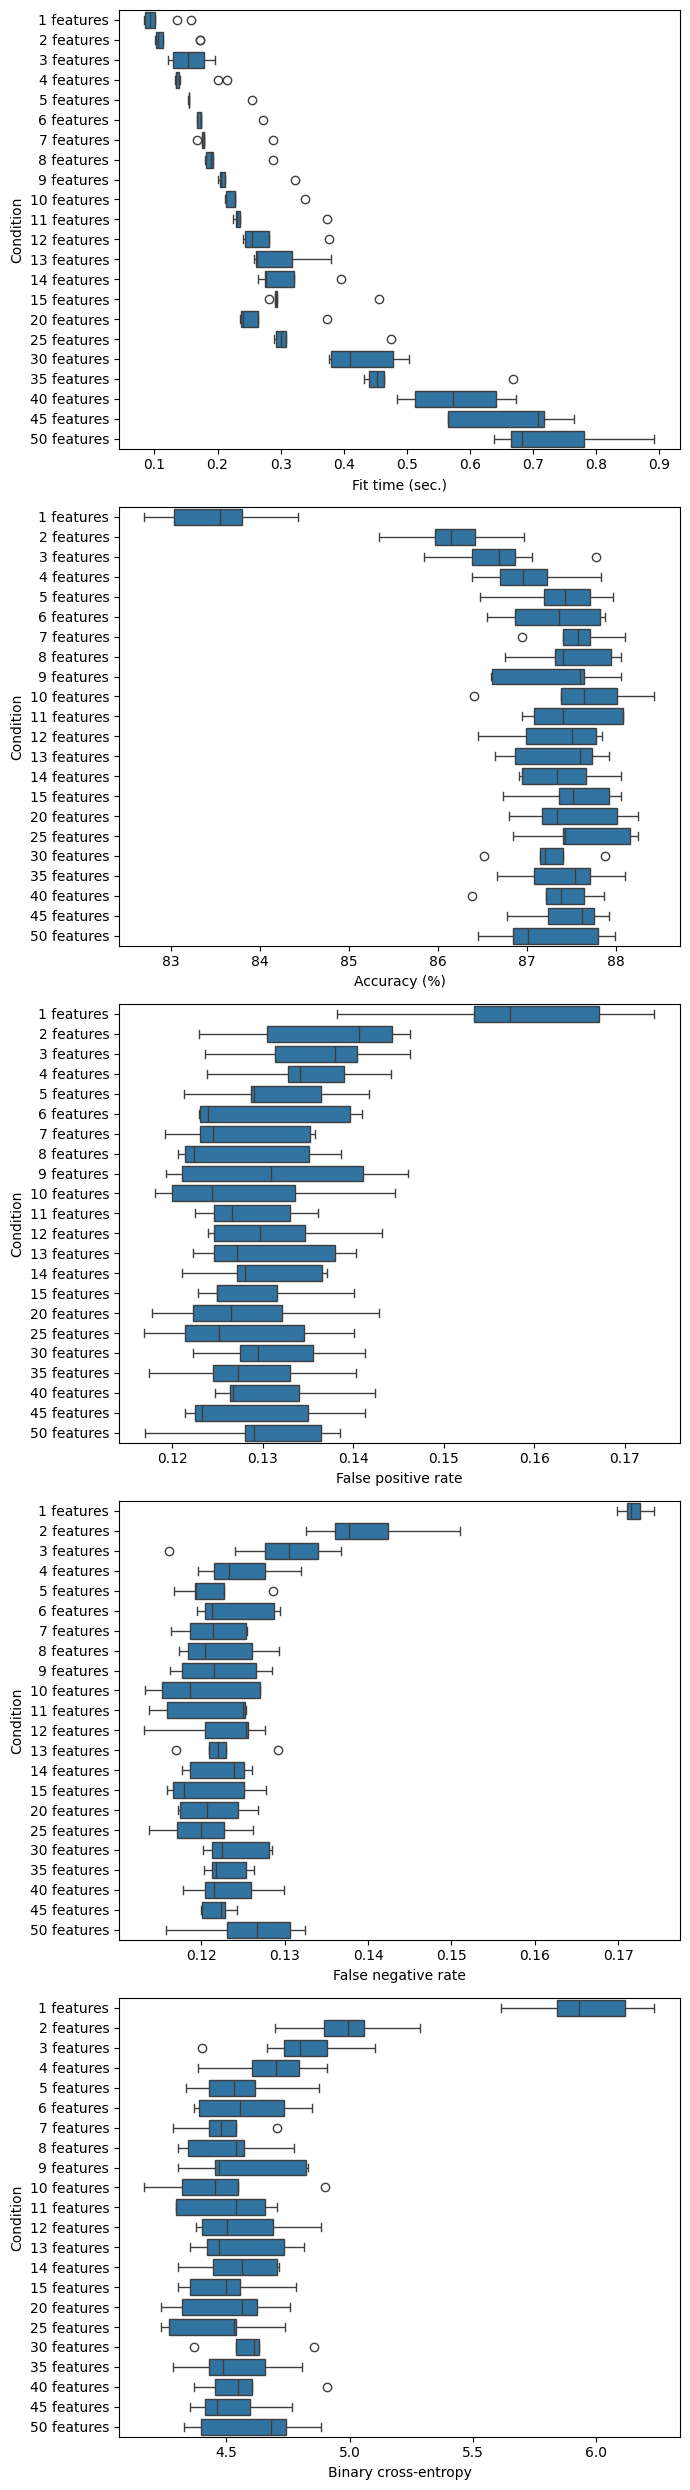

In [25]:
# The feature set sizes to test
feature_set_sizes = [10,15,20,25,30,35,40,45,50]

# Cross validation folds to run
kfolds = 5

# Number of jobs to run in parallel
parallel_jobs = 5

# Loop on the feature set sizes
for feature_set_size in feature_set_sizes:

    # Run sequential feature selection for this feature set size
    sfs, fitted_sfs = helper_funcs.sequential_feature_selection(
        features_train = spline_features_train, 
        labels_train = labels_train, 
        feature_count = feature_set_size, 
        cv_folds = kfolds,
        n_jobs = parallel_jobs
    )

    feature_set_train = fitted_sfs.transform(spline_features_train)
    print(f'Data shape: {feature_set_train.shape}')

    # Instantiate an XGBoost model using the sklearn API
    model = XGBClassifier()

    # Run cross-validation
    scores = cross_validate(
        model,
        feature_set_train,
        labels_train,
        cv = kfolds,
        n_jobs = parallel_jobs,
        scoring = scoring
    )

    # Collect the results
    results = helper_funcs.add_cv_scores(results, scores, f'{feature_set_size} features')

plot_funcs.plot_cross_validation(plots, results).show()

### 5.3. Polynomial synthetic feature set

In [ ]:
# Clear the results dictionary
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

In [26]:
# The feature set sizes to test
feature_set_sizes = [10,15,20,25,30,35,40,45,50]

# Cross validation folds to run
kfolds = 2

# Number of jobs to run in parallel
parallel_jobs = 5

# Loop on the feature set sizes
for feature_set_size in feature_set_sizes:

    # Run sequential feature selection for this feature set size
    sfs, fitted_sfs = helper_funcs.sequential_feature_selection(
        features_train = poly_features_train, 
        labels_train = labels_train, 
        feature_count = feature_set_size, 
        cv_folds = kfolds,
        n_jobs = parallel_jobs
    )

    feature_set_train = fitted_sfs.transform(poly_features_train)
    print(f'Data shape: {feature_set_train.shape}')

    # Instantiate an XGBoost model using the sklearn API
    model = XGBClassifier()

    print(f'Model is: {type(model)}\n')

    # Run cross-validation
    scores = cross_validate(
        model,
        feature_set_train,
        labels_train,
        cv = kfolds,
        n_jobs = parallel_jobs,
        scoring = scoring
    )

    # Collect the results
    results = helper_funcs.add_cv_scores(results, scores, f'{feature_set_size} features')

plot_funcs.plot_cross_validation(plots, results).show()

Data shape: (21443, 20)
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Data shape: (21443, 25)
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Data shape: (21443, 30)
Model is: <class 'xgboost.sklearn.XGBClassifier'>

